<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Bimatrix_Dynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Parameters
alpha = 0.6    # Probability of a good paper
epsilon = 0.1  # Probability of misclassifying a good paper as bad
lam = 0.1      # Probability of misclassifying a bad paper as good
r = 1.0        # Reward for author when accepted
c = 0.5        # Cost for author when rejected
gamma = 0.1    # NEW: Cost for journal when reviewing a paper

strategies = [0, 1, 2, 3]  # Always, Only Good, Only Bad, None

# Function to calculate acceptance probability
def acceptance_probability(is_good_paper, journal_strategy):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0



In [ ]:
def author_journal_payoff(author_strategy, journal_strategy):
    if author_strategy == 0:
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:
        good_prob, bad_prob = 0, 1 - alpha
    else:
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy)
    p_accept_bad = acceptance_probability(False, journal_strategy)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Payoff equation
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate - gamma * submit_rate
    else:
        journal_payoff = 0  # pay nothing if no receive paper

    return author_payoff, journal_payoff



def build_payoff_matrices():
    num_strategies = len(strategies)

    # Initialize payoff matrices
    author_payoff_matrix = np.zeros((num_strategies, num_strategies))
    journal_payoff_matrix = np.zeros((num_strategies, num_strategies))

    # Calculate payoffs for all strategy combinations
    for i, author_strat in enumerate(strategies):
        for j, journal_strat in enumerate(strategies):
            author_pay, journal_pay = author_journal_payoff(author_strat, journal_strat)
            author_payoff_matrix[i, j] = author_pay
            journal_payoff_matrix[i, j] = journal_pay

    return author_payoff_matrix, journal_payoff_matrix



In [ ]:
# Replicator dynamics for authors and journals
def replicator_dynamics(y, t, author_matrix, journal_matrix):
    # Strategy frequencies
    author_freqs = y[:4]
    journal_freqs = y[4:]

    # Frequencies are valid
    author_freqs = np.clip(author_freqs, 0, 1)
    journal_freqs = np.clip(journal_freqs, 0, 1)

    # Sum equals 1
    author_freqs = author_freqs / np.sum(author_freqs)
    journal_freqs = journal_freqs / np.sum(journal_freqs)

    # Expected payoffs for each strategy
    author_expected_payoffs = np.dot(author_matrix, journal_freqs)
    journal_expected_payoffs = np.dot(author_freqs, journal_matrix)

    # Average payoffs
    avg_author_payoff = np.dot(author_freqs, author_expected_payoffs)
    avg_journal_payoff = np.dot(journal_freqs, journal_expected_payoffs)

    # Replicator equation
    author_derivs = author_freqs * (author_expected_payoffs - avg_author_payoff)
    journal_derivs = journal_freqs * (journal_expected_payoffs - avg_journal_payoff)

    # Combine derivatives and return
    return np.concatenate([author_derivs, journal_derivs])

# Solve the ODE
def simulate_dynamics():
    author_matrix, journal_matrix = build_payoff_matrices()
    print("Author Payoff Matrix:")
    print(author_matrix)
    print("\nJournal Payoff Matrix:")
    print(journal_matrix)
    # Initial conditions 25% each
    initial_freqs = np.ones(8) / 4.0  # 4 author strategies, 4 journal strategies
    t = np.arange(0, 100.1, 0.1)
    solution = odeint(replicator_dynamics, initial_freqs, t, args=(author_matrix, journal_matrix))

    return t, solution, author_matrix, journal_matrix



Author Payoff Matrix:
[[ 1.    0.37  0.13 -0.5 ]
 [ 0.6   0.51 -0.21 -0.3 ]
 [ 0.4  -0.14  0.34 -0.2 ]
 [ 0.    0.    0.    0.  ]]

Journal Payoff Matrix:
[[ 0.5         0.83103448  0.04285714  0.        ]
 [ 0.94        0.94        0.94        0.        ]
 [-0.04       -0.04       -0.04        0.        ]
 [ 0.          0.          0.          0.        ]]


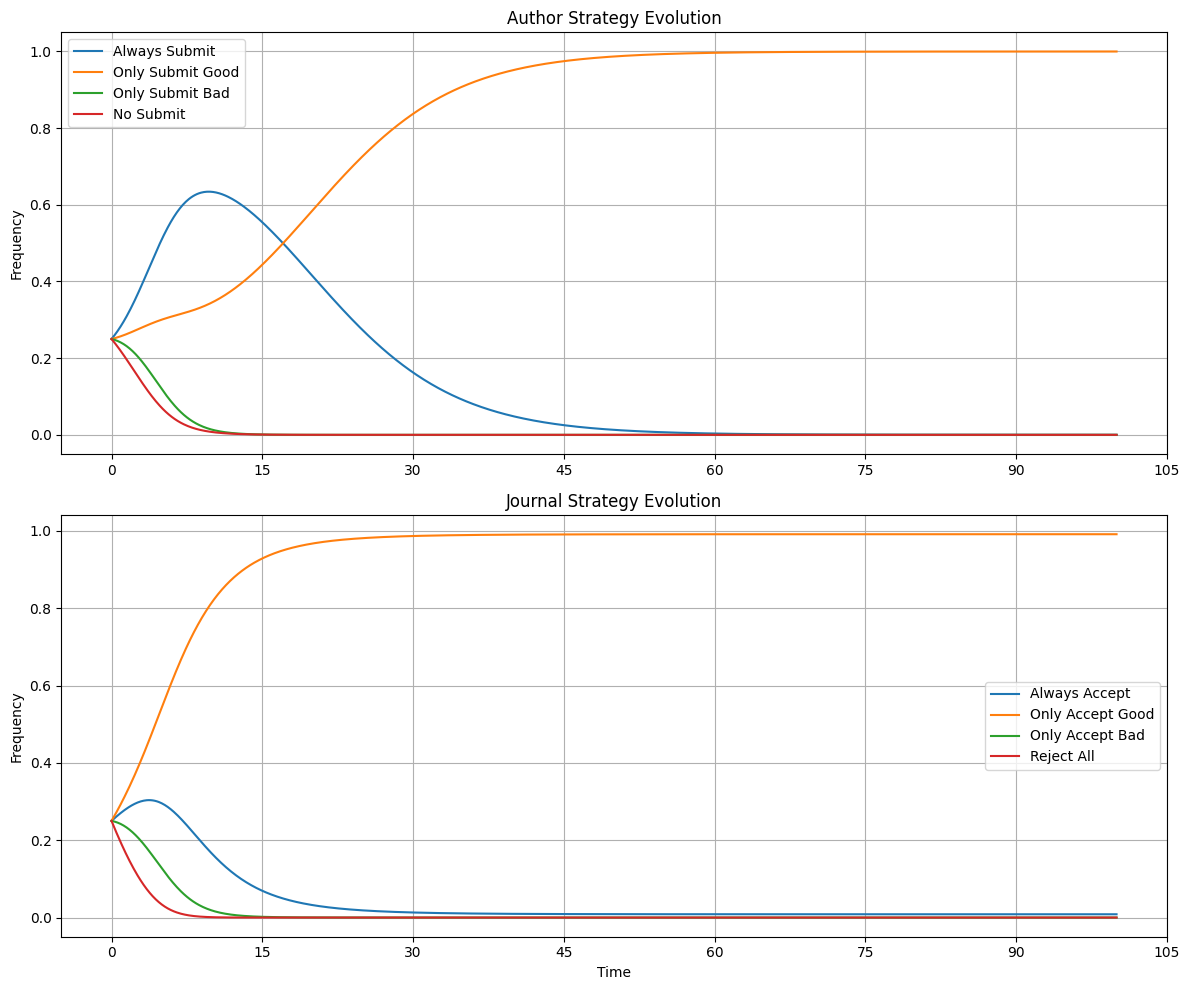


Final Strategy Distributions:
Author Strategies:
  Always Submit: 0.0000
  Only Submit Good: 1.0000
  Only Submit Bad: -0.0000
  No Submit: -0.0000

Journal Strategies:
  Always Accept: 0.0085
  Only Accept Good: 0.9915
  Only Accept Bad: 0.0000
  Reject All: -0.0000

Dominant strategies at convergence:
Author: Strategy 1
Journal: Strategy 1

This corresponds to: Authors Only Submit Good, Journals Only Accept Good

Payoffs at convergence:
Author: 0.5100
Journal: 0.9400

The system has converged to a Nash equilibrium.


In [ ]:
# Plot the results
def plot_results(t, solution):
    # Set up the plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Strategy names for legend
    author_strategies = ["Always Submit", "Only Submit Good", "Only Submit Bad", "No Submit"]
    journal_strategies = ["Always Accept", "Only Accept Good", "Only Accept Bad", "Reject All"]

    # Plot author strategy frequencies
    for i in range(4):
        ax1.plot(t, solution[:, i], label=author_strategies[i])
    ax1.set_ylabel('Frequency')
    ax1.set_title('Author Strategy Evolution')
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot journal strategy frequencies
    for i in range(4):
        ax2.plot(t, solution[:, i+4], label=journal_strategies[i])
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Journal Strategy Evolution')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

    # Print the final strategy distributions
    print("\nFinal Strategy Distributions:")
    print("Author Strategies:")
    for i, strategy in enumerate(author_strategies):
        print(f"  {strategy}: {solution[-1, i]:.4f}")

    print("\nJournal Strategies:")
    for i, strategy in enumerate(journal_strategies):
        print(f"  {strategy}: {solution[-1, i+4]:.4f}")

# Run the simulation
def main():
    t, solution, author_matrix, journal_matrix = simulate_dynamics()
    plot_results(t, solution)

    # Check if solution converged to a Nash equilibrium
    final_state = solution[-1, :]
    author_final = final_state[:4]
    journal_final = final_state[4:]

    # Find dominant strategies (those with highest frequency)
    dominant_author = np.argmax(author_final)
    dominant_journal = np.argmax(journal_final)

    print(f"\nDominant strategies at convergence:")
    print(f"Author: Strategy {dominant_author}")
    print(f"Journal: Strategy {dominant_journal}")

    # Check if this is a Nash equilibrium by looking at the payoff matrices
    author_strats = ["Always Submit", "Only Submit Good", "Only Submit Bad", "No Submit"]
    journal_strats = ["Always Accept", "Only Accept Good", "Only Accept Bad", "Reject All"]

    print(f"\nThis corresponds to: Authors {author_strats[dominant_author]}, Journals {journal_strats[dominant_journal]}")

    # See if there are any better responses for either player
    author_payoff = author_matrix[dominant_author, dominant_journal]
    journal_payoff = journal_matrix[dominant_author, dominant_journal]

    print(f"\nPayoffs at convergence:")
    print(f"Author: {author_payoff:.4f}")
    print(f"Journal: {journal_payoff:.4f}")

    # Check for better author responses
    better_author_response = False
    for i in range(4):
        if author_matrix[i, dominant_journal] > author_payoff:
            better_author_response = True
            print(f"Authors could improve by switching to strategy {i} ({author_strats[i]})")
            print(f"New payoff would be: {author_matrix[i, dominant_journal]:.4f}")

    # Check for better journal responses
    better_journal_response = False
    for j in range(4):
        if journal_matrix[dominant_author, j] > journal_payoff:
            better_journal_response = True
            print(f"Journals could improve by switching to strategy {j} ({journal_strats[j]})")
            print(f"New payoff would be: {journal_matrix[dominant_author, j]:.4f}")

    if not better_author_response and not better_journal_response:
        print("\nThe system has converged to a Nash equilibrium.")
    else:
        print("\nThe system has not converged to a Nash equilibrium, but to a stable state in the population dynamics.")

if __name__ == "__main__":
    main()